# PI² Research & Exploration - Advanced Stochastic Volatility Models

Volatility is not constant in real markets. In this notebook, we study the Heston and SABR models that capture stochastic behavior of volatility, and allow better option pricing and volatility surface fitting.

## Introduction

### An overview of volatility modelling in finance.

Volatility is one of the most fundamental and studied concepts in quantitative finance. It measures the degree of variation or uncertainty in the price of a financial asset over time, reflecting how much returns deviate from their average value. In practical terms, high volatility implies larger and more unpredictable price swings, often associated with greater risk and potential reward for investors.

Classic financial models like Black–Scholes assume constant volatility, a simplification that makes analytic pricing possible but fails to capture real market behavior. Actual market volatility is time-varying, persistent, and exhibits asymmetric behavior: volatility tends to rise more after negative shocks than after positive ones.

Since the 1970s, multiple generations of volatility models have been developed to address these limitations. Statistical approaches, such as ARCH and GARCH models (Engle, R.), introduce conditional heteroskedasticity to describe volatility’s dynamics, while more advanced frameworks like stochastic volatility models treat volatility itself as a random process evolving according to its own SDE.

These developments have significantly improved the realism and predictive power of financial models. Stochastic volatility frameworks like the Heston and SABR models allow volatility to vary randomly over time and capture phenomena such as mean reversion, volatility smiles, and correlations between asset returns and variance.

## Mathematical Background

In the Black-Scholes model, the asset price is the only stochastic process, following a geometric brownian motion:

$$dS_t = \mu \cdot S_t \cdot dt + \sigma \cdot S_t \cdot dW^P_t$$

The log return follows a gaussian distribution:
$$\left\{
\begin{aligned}
S_T &= S_0 \cdot e^{\left(\mu - \frac{\sigma^2}{2}\right) \cdot T + \sigma \cdot W_T} \\
\ln\!\left(\frac{S_T}{S_0}\right) &\sim \mathcal{N}\!\left(\left(\mu - \frac{\sigma^2}{2}\right) \cdot T,\, \sigma^2 \cdot T\right)
\end{aligned}
\right.$$

In practice, historical returns have fatter tails.

For instance, let's take a look at the daily returns of the S&P500:

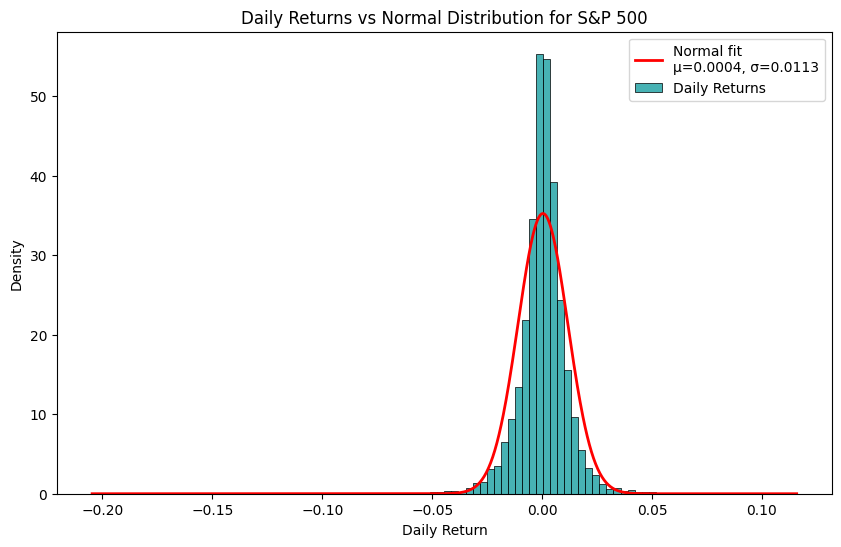

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# daily data from 1986 to 2018 (from Kaggle)
sp500 = pd.read_csv("spx.csv")
sp500["Return"] = sp500["close"].pct_change().dropna()
mu, sigma = sp500["Return"].mean(), sp500["Return"].std()

# Plot histogram
plt.figure(figsize=(10,6))
sns.histplot(sp500["Return"], bins=100, kde=False, color="#09999B", stat='density', label='Daily Returns')

# Plot normal distribution
x = np.linspace(sp500["Return"].min(), sp500["Return"].max(), 1000)
plt.plot(x, norm.pdf(x, mu, sigma), 'r', lw=2, label=f'Normal fit\nμ={mu:.4f}, σ={sigma:.4f}')

plt.title(f'Daily Returns vs Normal Distribution for S&P 500')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.show()

As we can see, returns are skewed to the left and have a fat tail.

Also, actual volatility changes with time and we tend to observe higher volatilities in periods of market stress when stock returns are more negative. 

## Bibliography: 
- Ribeiro, M. (2018). *Volatility Models in Option Pricing*, Master’s thesis, Instituto Superior Técnico.
- Quant Next. *Introduction to Stochastic Volatility Models*, [Website](https://quant-next.com/introduction-to-stochastic-volatility-models/).
- Yadav, P. (2024). *The SABR Volatility Model: Unlocking Realistic Market Behavior in Quantitative Finance*, [LinkedIn](https://www.linkedin.com/pulse/sabr-volatility-model-unlocking-realistic-market-behavior-yadav-r3kkc/).
- Chang, H. (2024). *Stochastic volatility models and their applications to financial markets*, Xi'an Jiaotong-Liverpool University, [Publication](https://www.ewadirect.com/proceedings/aemps/article/view/18738).